- Proportional 

Clusters:



In [37]:
import pdb
import random
from collections import OrderedDict
from imp import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display
from sklearn.decomposition import PCA

from acs import ACSCountyReader, read_merge_acs
from hud_geo_conversions import read_zips_to_fips
from jdata import JData
from jdata_counties import JDataCounties
from map_maker import draw_county_data_svg
from probplots import plot_dists_pps
from religion_census import read_judaic_cngs
from utilities import (display_cb, is_outlier_instance, is_outlier_val,
                       read_fips_codes)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

SEED = 42
random.seed(SEED)

In [38]:
DATA_DIR    = '../Data/'
IMG_DIR = '../Images/'

DEM_DIR = ''.join([DATA_DIR, 'Demography/'])
SCL_DIR = ''.join([DATA_DIR, 'Schools/'])
REL_DIR  = ''.join([DATA_DIR, 'Religion/'])

ZIPS_TO_FIPS_FP = ''.join([DATA_DIR, 'ZIP_COUNTY_122016.xlsx'])
FIPS_TO_ZIPS_FP = ''.join([DATA_DIR, 'COUNTY_ZIP_122016.xlsx'])
FIPS_CODES_FP   = ''.join([DATA_DIR, 'Census-2010-County-FIPS.txt'])

# ACS data files
POP_FP           = ''.join([DEM_DIR, 'ACS_15_5YR_B01003/',
                            'ACS_15_5YR_B01003_with_ann.csv'])
FOREIGN_BIRTH_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B05006/', 
                                'ACS_15_5YR_B05006_with_ann.csv'])
SNGL_ANCE_FP     = ''.join([DEM_DIR, 'ACS_15_5YR_B04004/',
                            'ACS_15_5YR_B04004_with_ann.csv'])
MULT_ANCE_FP     = ''.join([DEM_DIR, 'ACS_15_5YR_B04005/',
                           'ACS_15_5YR_B04005_with_ann.csv'])
ALL_ANCE_FP      = ''.join([DEM_DIR, 'ACS_15_5YR_B04006/',
                            'ACS_15_5YR_B04006_with_ann.csv'])

# US Religion Census data files
RELCEN_CB_FP  = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File-CB.TXT'])
RELCEN_FP = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File.DTA'])

# JData.org data file
JDATA_FP = ''.join([SCL_DIR, 'jdata_directory.json'])

# zip_to_fips =  read_zips_to_fips(ZIPS_TO_FIPS_FP)
# fips_codes = read_fips_codes(FIPS_CODES_FP)

## Merge Tables

Choosing to use counties instead of zips because zips are more likely to conflate same areas

Scaling methodology

- Try LDA, Factor Analysis

In [39]:
from imp import reload
import jdata_counties
reload(jdata_counties)
from jdata_counties import JDataCounties, JData

jdc = JDataCounties(JDATA_FP, ZIPS_TO_FIPS_FP)
jd_fips = jdc.get_county_cnts(exclude=['DayCamp', 'OverCamp'])

jd_type, jd_denom = jd_fips.iloc[:, :3], jd_fips.iloc[:, 3:]

In [40]:
jd_type.head()

,Type_DaySch,Type_EarlyChild,Type_PTSch
FIPS,,,
01045,0.000,0.000,0.080
01069,0.000,0.000,0.920
01073,1.000,3.000,3.000
01081,0.000,0.000,0.987
01087,0.000,0.000,0.013


In [41]:
pop_df = ACSCountyReader(POP_FP).read_counties(geo=True)
pop_df.head()

,County,State,Tot
FIPS,,,
01001,Autauga County,AL,55221
01003,Baldwin County,AL,195121
01005,Barbour County,AL,26932
01007,Bibb County,AL,22604
01009,Blount County,AL,57710


In [6]:
def to_not_born_isr(df, ance_col='Ance_Isr', born_col='Born_Isr'):
    """Converts Israeli ancestry to subset: those not born there."""
#     return  df
    diff = df[ance_col] - df[born_col]
    df.loc[:, ance_col] = diff
    df = df.rename(columns={ance_col: 'NonBorn_Isr'})
    return df

params = [
    dict(name='Ance_Isr', kw='Israeli', fp=ALL_ANCE_FP),
    dict(name='Born_Isr', kw='Israel',  fp=FOREIGN_BIRTH_FP),
    ]

acs_df = read_merge_acs(params)

In [42]:
relcen = (read_judaic_cngs(RELCEN_FP, standard_cols=False)
#           .drop(['UnionMessJews_Cngs'], axis=1)
)

In [8]:
counties = pd.concat([jd_fips, relcen, acs_df], axis=1).fillna(0)

In [9]:
counties.head()

,Type_DaySch,Type_EarlyChild,Type_PTSch,Denom_Consv,Denom_NonDenom,Denom_Orth,Denom_Recon,Denom_Ref,ConsvJud_Cngs,OrthJud_Cngs,ReconJud_Cngs,RefJud_Cngs,UnionMessJews_Cngs,Ance_Isr,Born_Isr
01007,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,0.000
01015,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,16.000,16.000
01045,0.000,0.000,0.080,0.000,0.000,0.000,0.000,0.080,0.000,0.000,0.000,0.000,0.000,9.000,0.000
01047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
01055,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,15.000


In [10]:
data = (pop_df.join(counties, how='right')
        .assign(Tot_Orgs=counties.loc[
            'Type_DaySch': 'RefJud_Cngs'].sum(1))
)

data = (data.loc[:, ['County', 'State', 'Tot', 'Tot_Orgs']]
        .assign(Isr_per_Org=(counties.Ance_Isr/data.Tot_Orgs).replace(np.inf, 0).fillna(0))
        .sort_values('Tot', ascending=False)
)

# outliers = pop_df.Tot[is_outlier_val(np.log(pop_df.Tot))]
# data = data.loc[~data.index.isin(outliers.index)]

In [11]:
data.loc[data.Isr_per_Org<10].head()

,County,State,Tot,Tot_Orgs,Isr_per_Org
06037,Los Angeles County,CA,10038388,nan,0.000
17031,Cook County,IL,5236393,nan,0.000
48201,Harris County,TX,4356362,nan,0.000
04013,Maricopa County,AZ,4018143,nan,0.000
06073,San Diego County,CA,3223096,nan,0.000


In [12]:
data.Isr_per_Org.replace(np.inf, 0).fillna(0).describe()

count   1016.000
mean       0.000
std        0.000
min        0.000
25%        0.000
50%        0.000
75%        0.000
max        0.000
Name: Isr_per_Org, dtype: float64

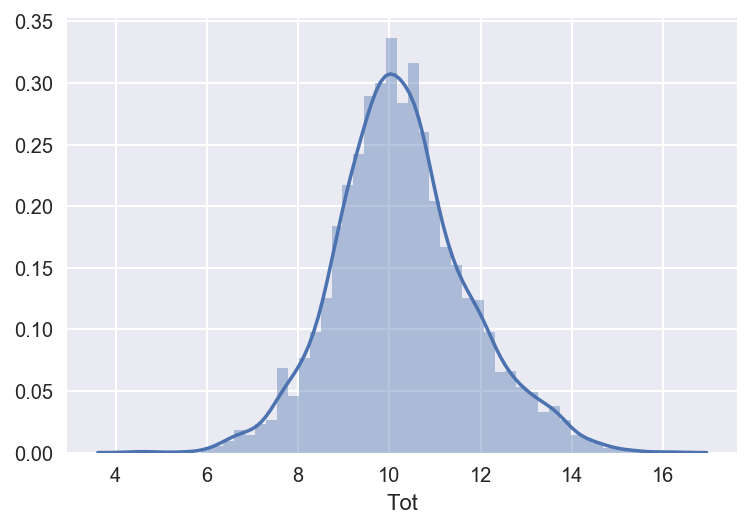

In [13]:
sns.distplot(np.log(pop_df.Tot))

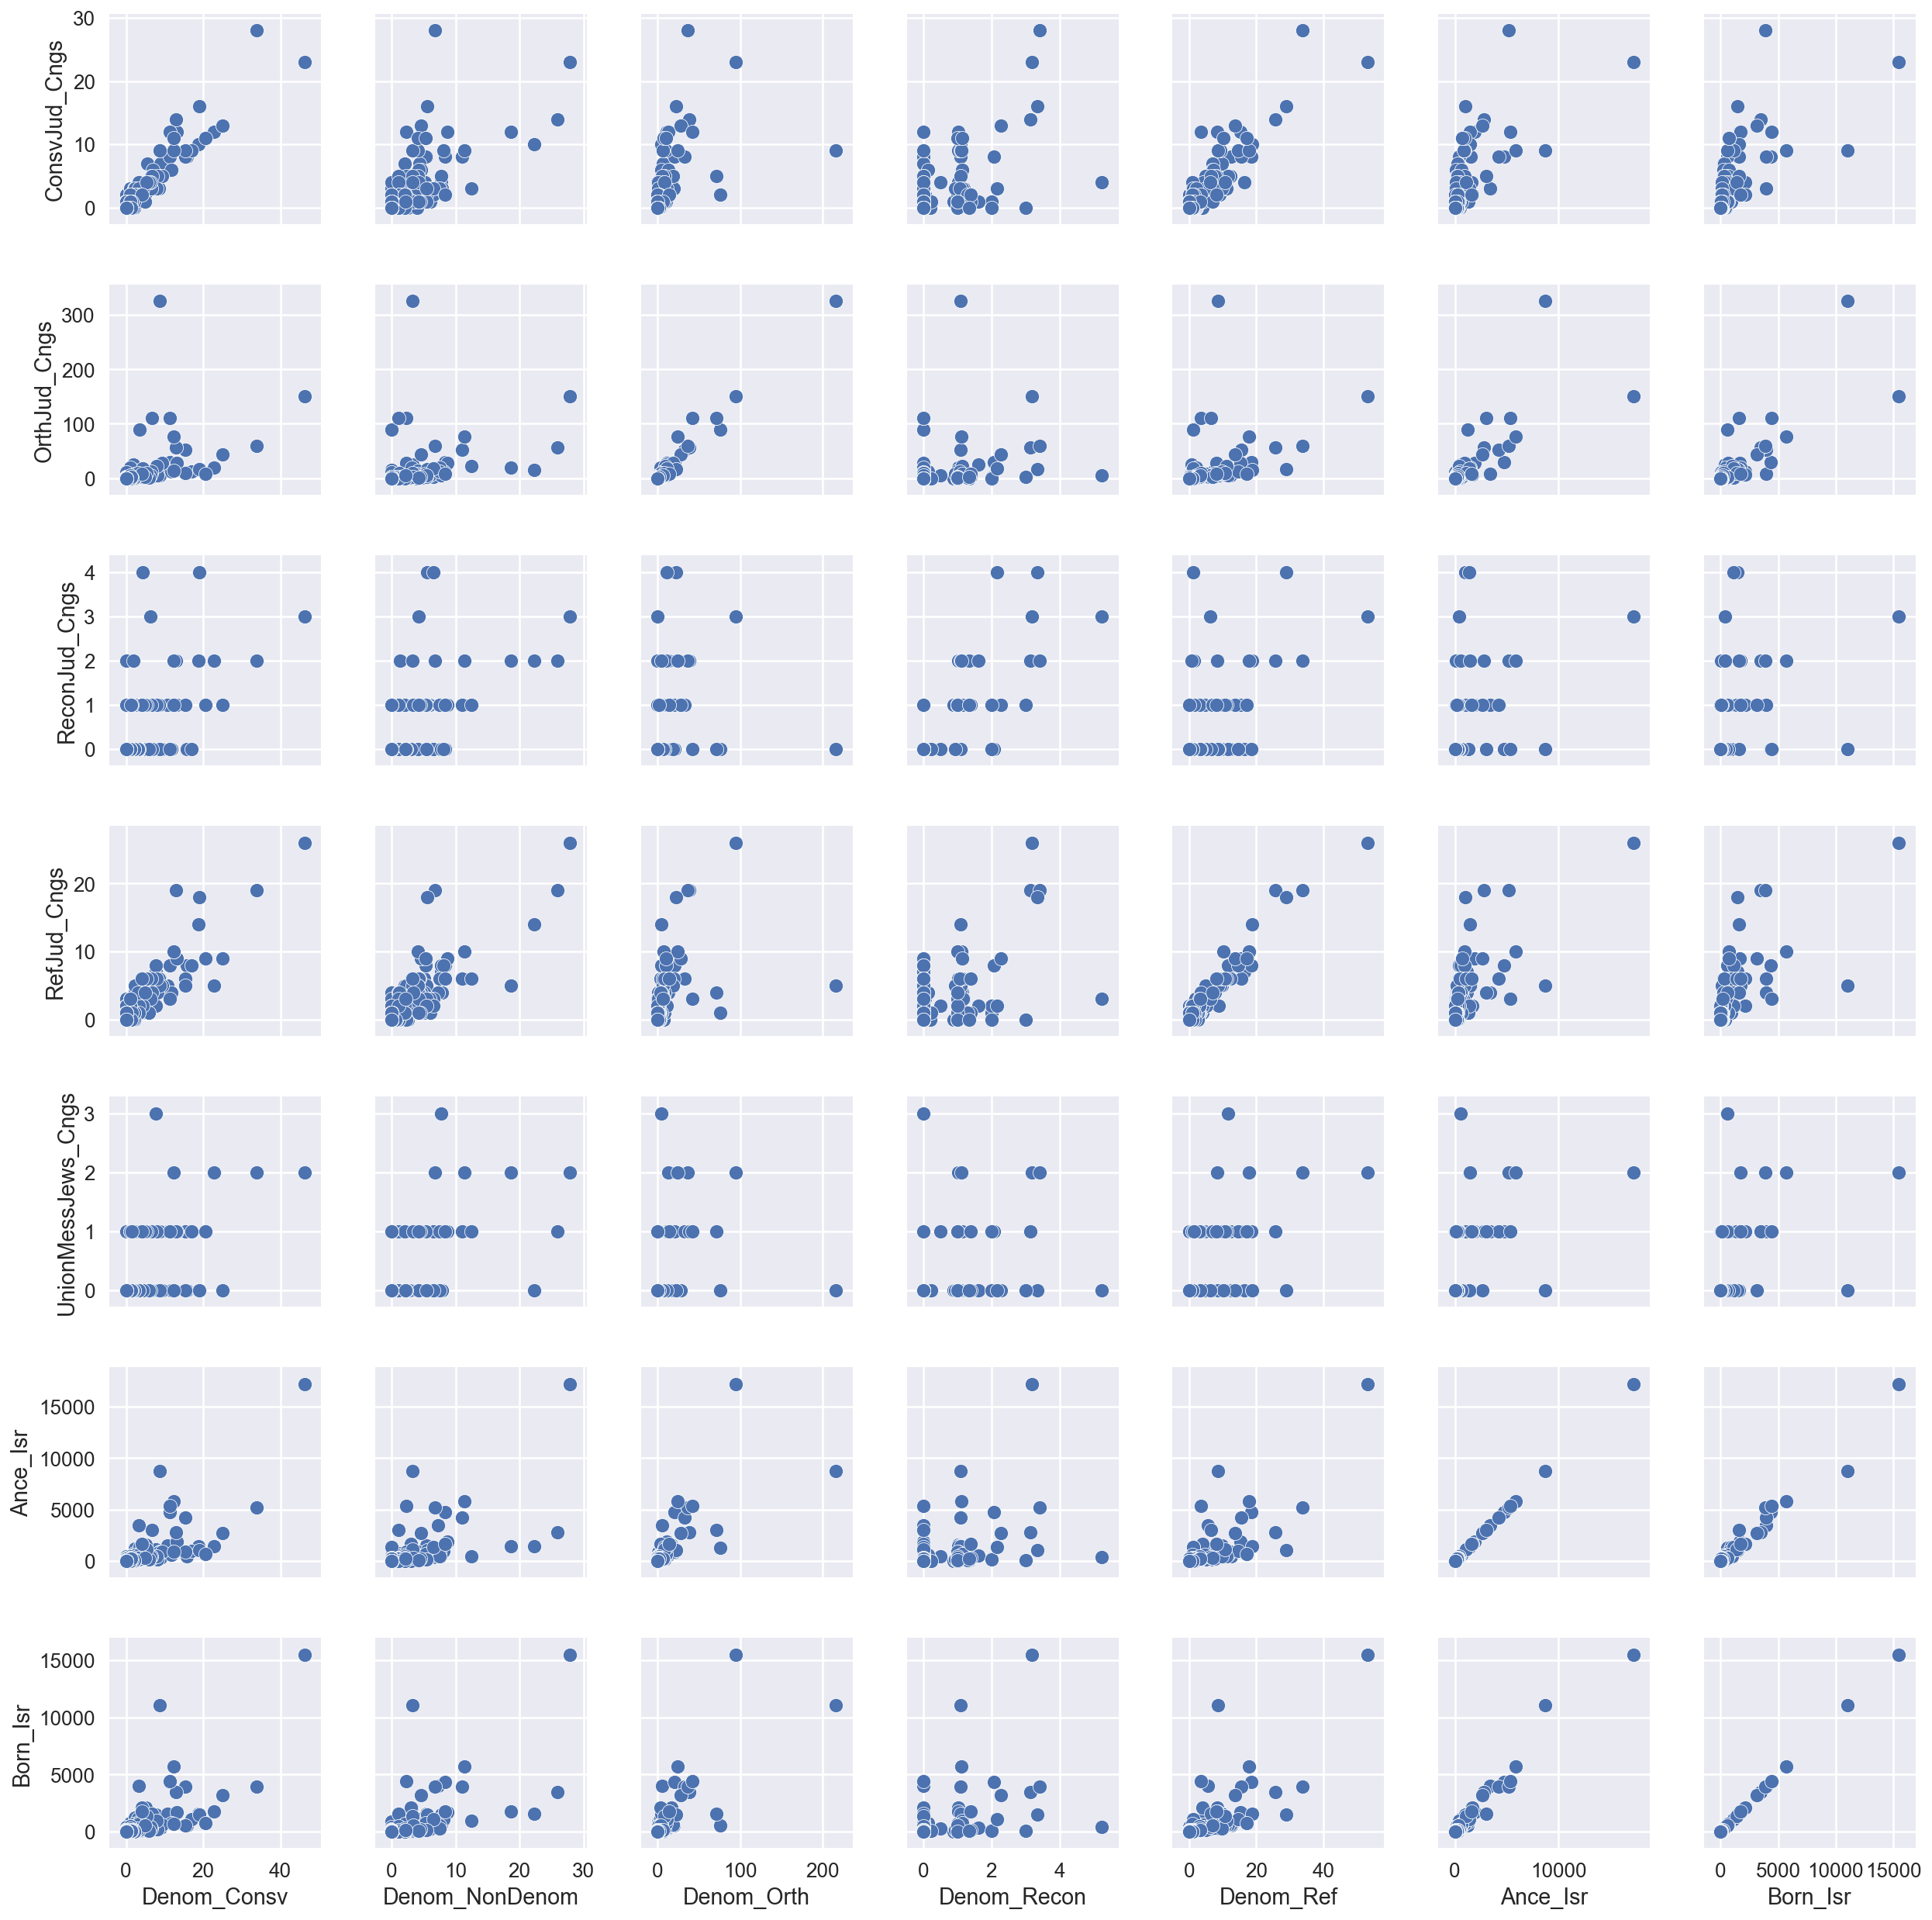

In [14]:
data = counties
x_vars = (data.loc[:, 'Denom_Consv': 'Denom_Ref'].columns.tolist()
          + ['Ance_Isr', 'Born_Isr']
)
y_vars = data.loc[:, 'ConsvJud_Cngs': 'Born_Isr'].columns.tolist()
                
with sns.plotting_context('talk'):
    g = sns.pairplot(data=counties, x_vars=x_vars, y_vars=y_vars)

plt.show()

In [15]:
# counties = counties.drop('Type_Early_childhood_center', axis=1)

In [16]:
counties[counties.sum(1)==1].head()

,Type_DaySch,Type_EarlyChild,Type_PTSch,Denom_Consv,Denom_NonDenom,Denom_Orth,Denom_Recon,Denom_Ref,ConsvJud_Cngs,OrthJud_Cngs,ReconJud_Cngs,RefJud_Cngs,UnionMessJews_Cngs,Ance_Isr,Born_Isr
01047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
05017,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
05031,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
05069,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
06047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000


In [19]:
from sklearn_pandas import DataFrameMapper

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

class LogScaleByTotal(TransformerMixin):
    """Logs counts normalized by all count total."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.log(X+1/np.sum(X+1))
    
class LogScaleBySubTotal(TransformerMixin):
    """Logs counts normalized by column total."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        def f(x): return np.log(x+1/np.sum(x+1))
        return np.apply_along_axis(f, 1, X)
    
class LogStandardScaler(StandardScaler):
    """Standardized logged data."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fit(self, X, y=None):
        return super().fit(np.log(X+1))
    
    def transform(self, X, y=None):
        return super().transform(np.log(X+1))

df = counties

scaler = LogScaleByTotal()
reducer = PCA()

pipe = Pipeline([
    ('scaler', scaler),
    ('reducer', reducer)
])
reduced = pipe.fit_transform(df)
print(reducer.explained_variance_ratio_)

# mapper = DataFrameMapper([
#     ([])
    
# ])

[ 0.51207598  0.15458618  0.13777429  0.0579975   0.02520337  0.02339519
  0.01920547  0.01533782  0.01359336  0.01071017  0.00921221  0.00770223
  0.00658242  0.00372201  0.0029018 ]


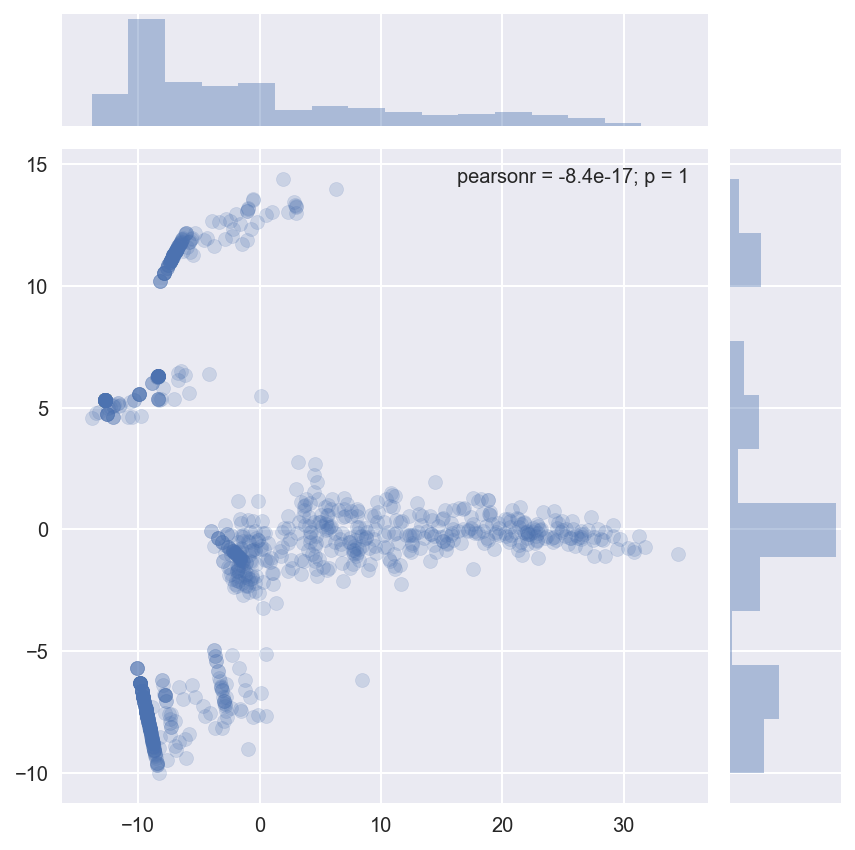

In [20]:
plt.figure(figsize=(10, 10))
sns.jointplot(x=reduced[:, 0], y=reduced[:, 1],
          alpha=.2)

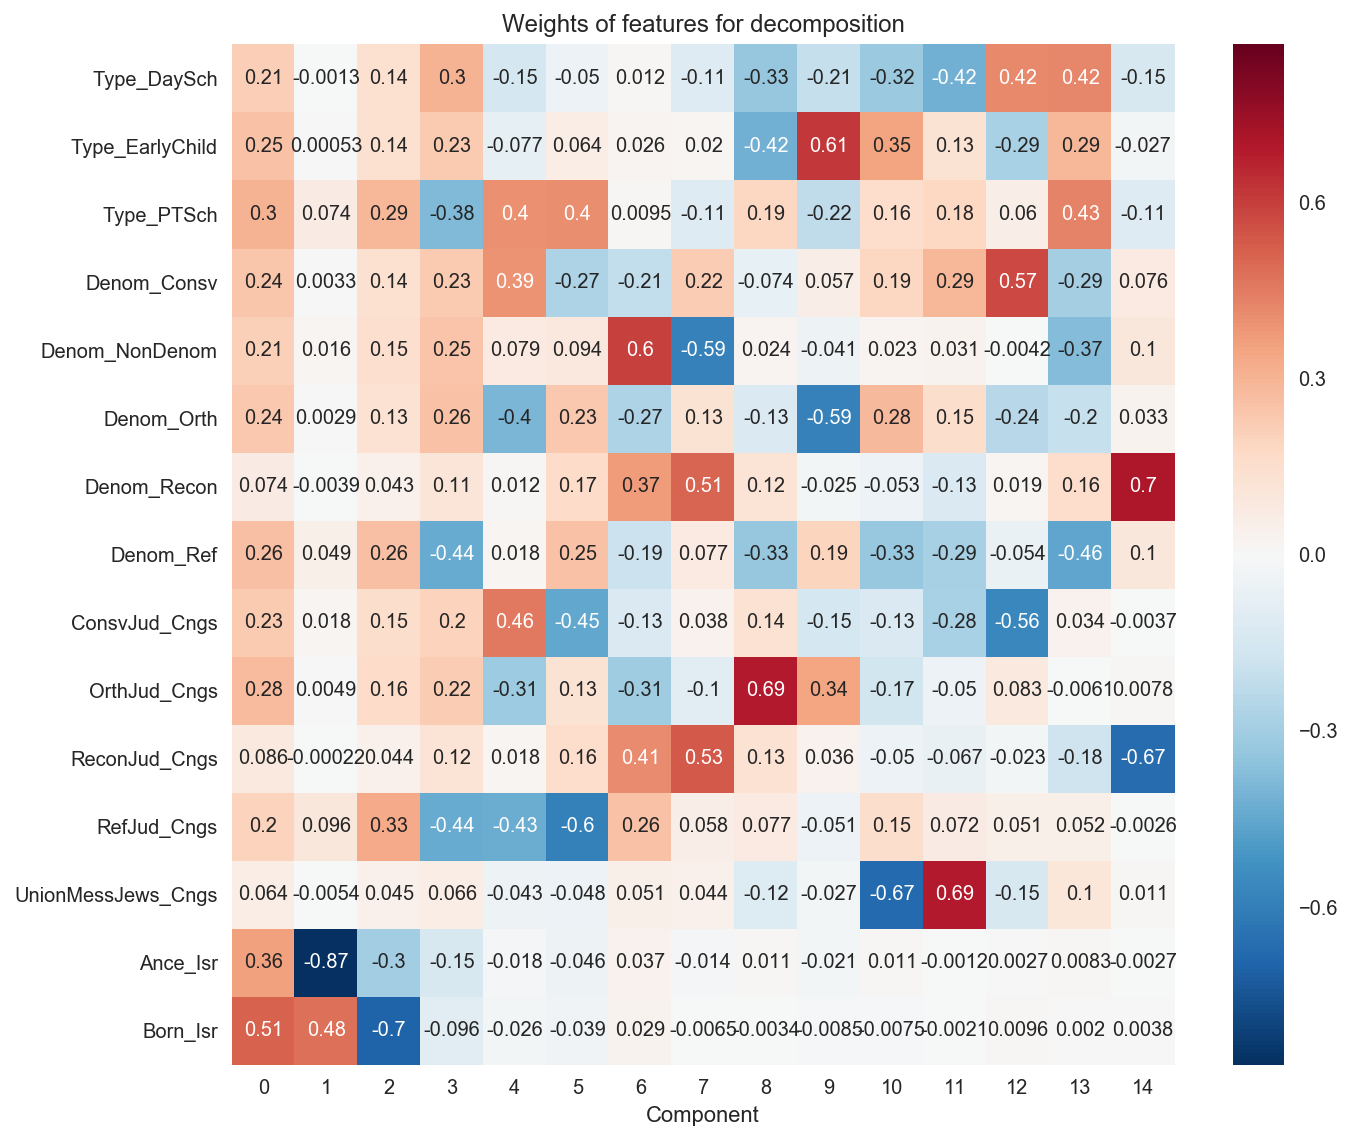

In [21]:
# comps = pd.DataFrame(reducer.components_, columns=data.columns)
plt.figure(figsize=(10, 8))
sns.heatmap(reducer.components_.T, yticklabels=df.columns.tolist(), annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

In [22]:
cnty_scl = pd.DataFrame(
    LogStandardScaler().fit_transform(counties),
    index=counties.index, columns=counties.columns)

In [23]:
cnty_scl.describe()

,Type_DaySch,Type_EarlyChild,Type_PTSch,Denom_Consv,Denom_NonDenom,Denom_Orth,Denom_Recon,Denom_Ref,ConsvJud_Cngs,OrthJud_Cngs,ReconJud_Cngs,RefJud_Cngs,UnionMessJews_Cngs,Ance_Isr,Born_Isr
count,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000,1016.000
mean,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.343,-0.407,-0.689,-0.431,-0.424,-0.381,-0.249,-0.607,-0.477,-0.423,-0.278,-0.784,-0.244,-1.255,-0.980
25%,-0.343,-0.407,-0.689,-0.431,-0.424,-0.381,-0.249,-0.607,-0.477,-0.423,-0.278,-0.784,-0.244,-1.255,-0.980
50%,-0.343,-0.407,-0.689,-0.431,-0.424,-0.381,-0.249,-0.607,-0.477,-0.423,-0.278,-0.784,-0.244,0.018,-0.025
75%,-0.343,-0.407,0.184,-0.431,-0.424,-0.381,-0.249,0.495,-0.477,-0.423,-0.278,0.528,-0.244,0.687,0.726
max,8.866,6.199,5.123,6.111,5.870,7.591,8.388,5.738,6.104,7.347,7.277,5.455,7.711,3.450,3.452


In [24]:
reducer = PCA(n_components=len(cnty_scl.T))
reducer.fit(cnty_scl)
reducer.explained_variance_ratio_.tolist()

[0.6943279529459636,
 0.073890584034829,
 0.04723677374778117,
 0.04121613055358304,
 0.03687864382908836,
 0.022556369231598317,
 0.021207311098508215,
 0.017621409922582452,
 0.011643229804222163,
 0.01031526635338643,
 0.007108898175129364,
 0.005394398993024923,
 0.005225703988980843,
 0.004440965706973007,
 0.0009363616143491767]

In [25]:
import hdbscan

In [26]:
clust = hdbscan.HDBSCAN(min_cluster_size=5).fit(cnty_scl)

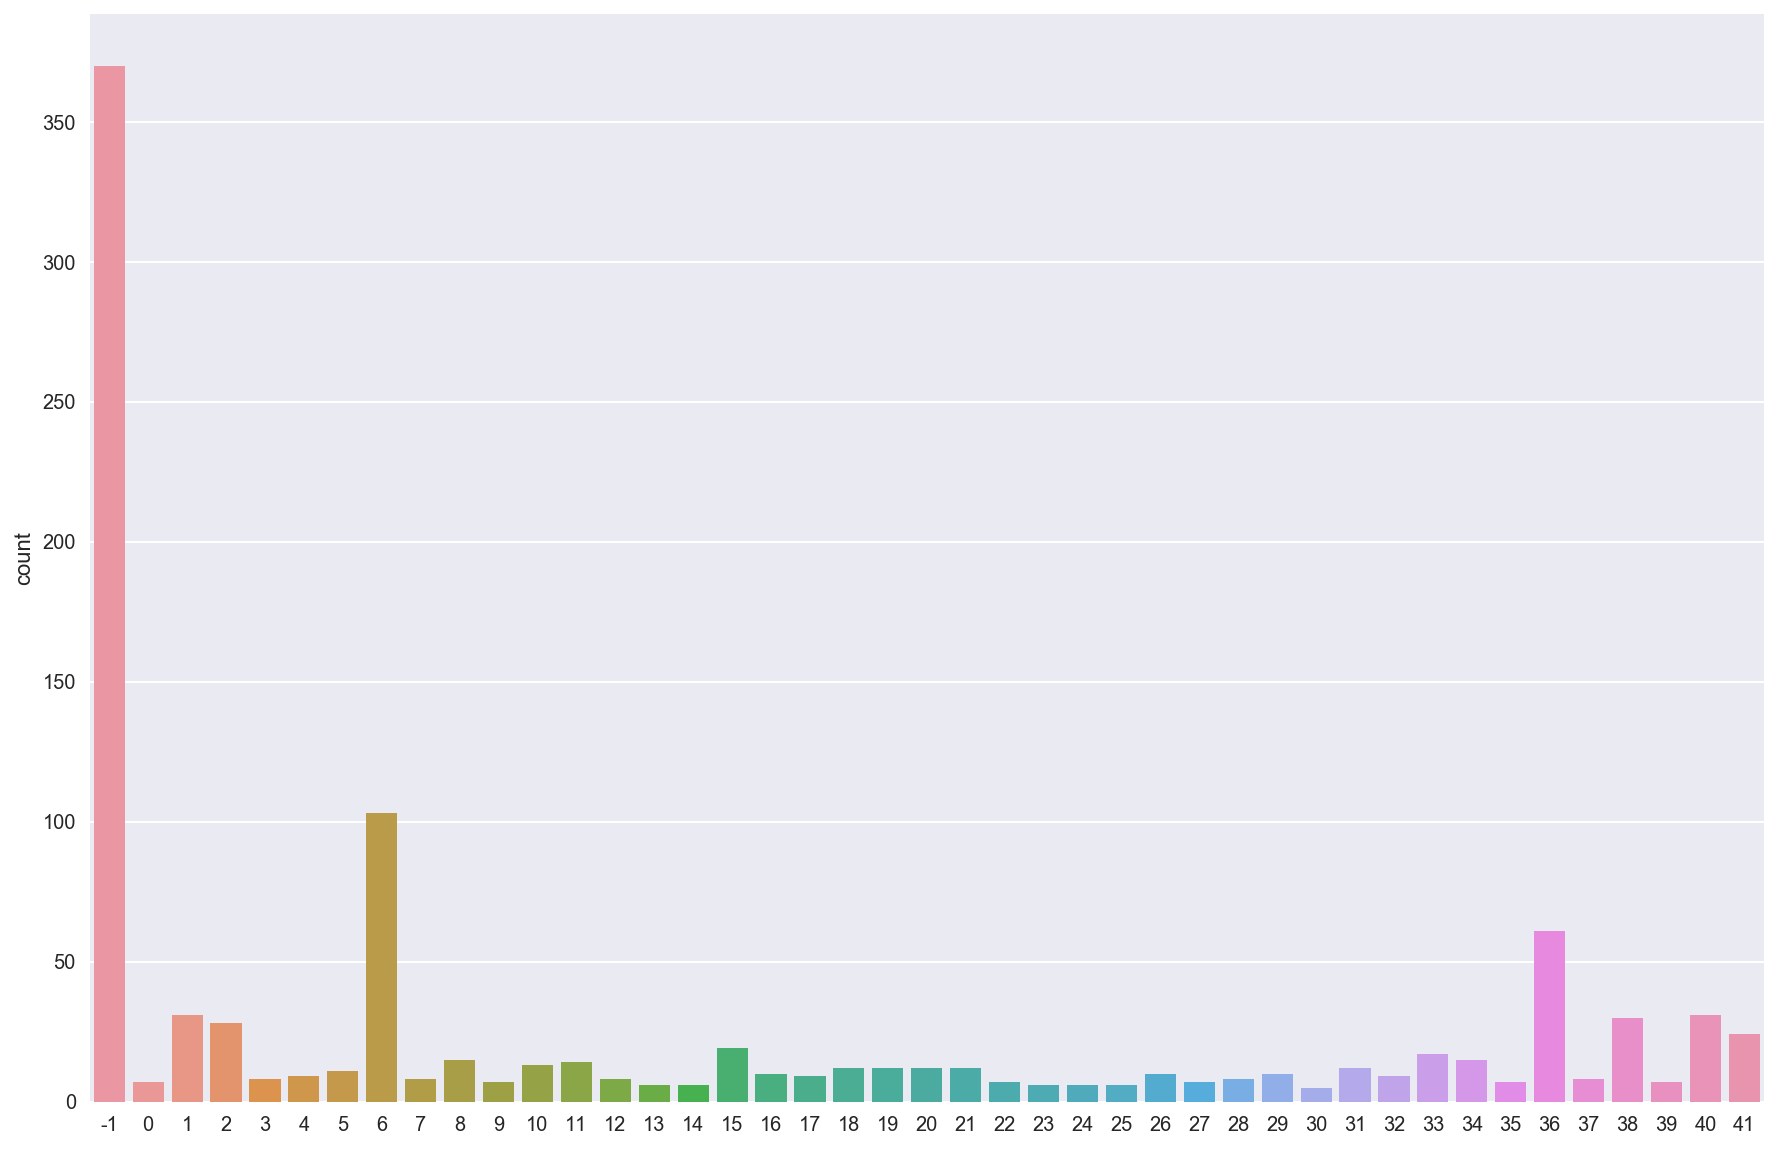

In [27]:
plt.figure(figsize=(15, 10))
sns.countplot(clust.labels_)


In [28]:
plt.figure(figsize=(5, 5))

sns.pairplot(data=data[data.cluster.isin(clust_n)], hue='cluster', )
plt.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [35]:
data = cnty_scl.assign(cluster=clust.labels_)

data = pd.melt(data, id_vars='cluster')

(15240, 3)

In [29]:
with sns.plotting_context('talk'):
    sns.stripplot(data=data[data.cluster>-1], x='cluster', hue='variable', y='value',
                  jitter=.2, alpha=.9)

with sns.plotting_context('talk'):
    sns.pointplot(data=data[data.cluster>-2], x='cluster', hue='variable', y='value',)

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [ ]:
reduced = reducer.transform(cnty_scl)
reduced = pd.DataFrame(reduced)
data= pd.concatr([reduced, pd.DataFrame(clust.labels_, columns=['Label'])], axis=1).head()

In [ ]:
sns.jointplot(x=1, y=0, data=data, hue='Label')

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for i in range(5, 10):
    clust = KMeans(20).fit(cnty_scl)
    score = silhouette_score(cnty_scl, clust.predict(cnty_scl))
    print(score)

# data = cnty[clust.labels_>-1]
# preds = clust.labels_[clust.labels_>-1]
# silhouette_score(data, preds)

In [ ]:
DIR = ''.join([IMG_DIR, 'play'])
colors = list(sns.color_palette('husl', len(np.unique(clust.labels_))).as_hex())
draw_county_data_svg(pd.Series(clust.labels_+1, index=cnty.index, name='clust'), DIR,
                     colors=colors, zero_color='#bebebe')

SVG(DIR)

In [ ]:
data = cnty.assign(cluster=clust.labels_)
sns.pointplot(x='cluster', y='Denom_Reform', data=data)

In [ ]:
ajpp_county = read_ajpp_county(AJPP_FP, AJPP_GEO_FP)

In [ ]:
data = (pd.DataFrame(clust.labels_, index=cnty.index, columns=['clust'])
        .join(ajpp_county))

sns.boxplot(x='clust', y='Jewish_By_Rel', data=data)
plt.semilogy();

In [ ]:
data = (pd.DataFrame(clust.labels_, index=cnty.index, columns=['clust'])
        .join(urb_rur))

sns.boxplot(x='clust', y='POPPCT_URBAN', data=data)

In [ ]:
data.groupby('pred').mean()

In [ ]:
data = cnty.assign(cluster=clust.labels_).groupby('cluster').count()
data

In [ ]:
data = (data
        .assign(cluster=clust.labels_).groupby('cluster').mean())
sns.heatmap(data=data)
plt.title('Compare Means of MinMaxScaled features.')

In [ ]:
data = (pd.DataFrame(MinMaxScaler().fit_transform(cnty),
                     columns=cnty.columns)
        .assign(cluster=clust.labels_).groupby('cluster').mean())
sns.heatmap(data=data)
plt.title('Compare Means of MinMaxScaled features.')

In [ ]:
from yellowbrick.features.rankd import Rank2D
from yellowbrick.features.radviz import RadViz
from yellowbrick.features.pcoords import ParallelCoordinates


visualizer = Rank2D(algorithm='covariance')

visualizer.fit(cnty)                # Fit the data to the visualizer
visualizer.transform(cnty)             # Transform the data
visualizer.poof();    # Draw/show/poof the data

In [ ]:
visualizer = ParallelCoordinates()

visualizer.fit(cnty.as_matrix(), np.random.randint(0, 5, 662))     # Fit the data to the visualizer
visualizer.transform(cnty)   # Transform the data
visualizer.poof()    ;     # Draw/show/poof the data

In [ ]:
rc_drop = ['County', 'State',
           'Tot_Cngs', 'Tot_No', 'Tot_Pc']

merged = (acs.join(urb_rur[['POPPCT_URBAN']])
          .join(jd_county, how='outer')
          .join(relcen.drop(rc_drop, axis=1), how='outer')
          .fillna(0))

In [ ]:
# dropping rows that are needed to be empty at first, i.e.
# drop_counties=False (default) for read_acs, because
# general population data is used for counties with only
# jdata org data
has_dat = (merged.loc[:, 'Only_Israeli_No':]!=0.).any(1)
merged = merged[has_dat]
merged.T.head()

In [ ]:
merged.shape, acs.shape, jd_county.shape, relcen.shape

In [ ]:
merged[stdrd_cols+cols].shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = merged[['Tot_Jews', 'Tot_JewCngs']]
scaled = pd.DataFrame(MinMaxScaler().fit_transform(x),
                      columns=['Tot_Jews_Sc', 'Tot_JewCngs_Sc'],
                      index=x.index)
x = pd.concat([x, scaled], axis=1)
# sns.pairplot(x, 

In [ ]:
stdrd_cols = ['Total_Pop']

cols = [
    'Only_Israeli_No',
    'Part_Israeli_No',
    'Tot_Israeli_No',
    'POPPCT_URBAN',
    
    'Denom_Conservative',
    'Denom_Orthodox',
    'Denom_Other',
    'Denom_Reconstructionist',
    'Denom_Reform',
    'Tot_Orgs',
    'ConsvJud_No',
    'OrthJud_No',
    'ReconJud_No',
    'RefJud_No',
    'UnionMessJews_Cngs',
    'Tot_Jews',
    'Tot_JewCngs',
    'Type_Day_school',
    'Type_Early_childhood_center',
    'Type_Part_time_school',]

sns.pairplot(merged[stdrd_cols+cols])

## Exploration

More info on SVGs:
http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/IPython%20Kernel/Rich%20Output.ipynb
http://flowingdata.com/2009/11/12/how-to-make-a-us-county-thematic-map-using-free-tools/
https://github.com/jaeahlee/svg-map-counties.git

In [ ]:
dat_no = merged.select(lambda x: not x.endswith('_Pc'), axis=1)
dat_tots = merged.select(lambda x: x.startswith('Tot') or x in ['County', 'State'], axis=1)
dat_tots = merged.select(lambda x: x.startswith('Tot_') and not x.endswith('_Pc'), axis=1)
dat_tots.head()

In [ ]:
has_relcen = (dat_tots.Tot_JewCngs!=0) | (dat_tots.Tot_Jews!=0)
has_acs = dat_tots.Tot_Israeli_No!=0
has_jdata = dat_tots.Tot_Orgs!=0

mer_has_dat = pd.DataFrame(dict(Congregants=has_relcen,
                                Israeli=has_acs,
                                Orgs=has_jdata))
n_sources= mer_has_dat.sum(1)

How much data do we have on counties?

In [ ]:
import map_maker
reload(map_maker)
from map_maker import draw_county_data_svg

DIR = ''.join([IMG_DIR, 'num_data_sources.svg'])

# Map colors
data = n_sources
bins = [1, 2, 3]

svg = draw_county_data_svg(data, DIR, bins=bins)

SVG(DIR)

In [ ]:
ax = sns.boxplot(x='Sources', y='Total_Pop', 
                 data=merged.join(n_sources.to_frame(name='Sources')))
ax.set_title('County population by number of data sources')
ax.set_yscale('log')
sns.despine()

In [ ]:
# fraction of counties with n data points
n_sources.value_counts(normalize=False).to_frame().T

In [ ]:
mer_has_dat[n_sources==1].sum()

In [ ]:
mer_has_dat.sum()

In [ ]:
plt.hist

In [ ]:
fig, ax = plt.subplots()
legend = []
for i in range(1, 4):
    sns.distplot(merged[n_sources==i].POPPCT_URBAN, bins=100, kde=False,
                 hist_kws=dict(cumulative=True, label=str(i)), ax=ax)
    legend.append(str(i))
plt.legend(legend)

In [ ]:
merged[(dat_tots==0).sum(1)==3]

In [ ]:
from ajpp import read_ajpp_geo
ajpp_geo = read_ajpp_geo(AJPP_GEO_FP)
ajpp_geo.Region.to_frame().join(merged[n_sources==1], how='inner').head()

In [ ]:
merged[n_sources==1].sort_values('Tot_Orgs', ascending=False).loc[:, :'Tot_Orgs']

In [ ]:
import map_maker
reload(map_maker)
from map_maker import draw_county_data_svg

DIR = ''.join([IMG_DIR, 'num_data_exploring.svg'])

data = merged[n_sources==1].Tot_Orgs
bins = [1, 2, 3, 4]
color_pal = sns.color_palette('Reds', n_colors=len(bins))
sns.palplot(color_pal)
colors = color_pal.as_hex()

svg = draw_county_data_svg(data, DIR, colors, bins)

SVG(DIR)

In [ ]:
x = dat_no.columns[10:22]
y = dat_no.columns[[24, 26, 28, 30]]
dat = dat_no
sns.pairplot(x_vars=x, y_vars=y, data=dat)

In [ ]:
dat_no.assign(j_pc=dat_no.Tot_Jews/dat_no.Total_Pop).sort_values('j_pc', ascending=False)
dat_no.sort_values('Total_Pop', ascending=False)
sum(dat_no.Total_Pop<1000000)

In [ ]:
dat_no.Total_Pop.describe()

In [ ]:
plt.hist(dat_no.Total_Pop, cumulative=True, bins=1000, normed=True);

In [ ]:
ProbPlots(dat_no.Total_Pop).plot_probplot('lognorm')

In [ ]:
def plot_n_nonzeros(df):
    plt.hist((df!=0).sum(1), cumulative=True, normed=True, bins=1000, align='mid')
# plot_n_nonzeros(dat_no.iloc[:, 2:])
# plot_n_nonzeros(dat_tots)

In [ ]:
plt.hist(dat_tots.Tot_Jews, cumulative=True, bins=1000, normed=True);

In [ ]:



dat_tots[~is_outlier_instance(dat_tots.Tot_JewCngs)].shape

In [ ]:
sum(dat_tots.Tot_Jews==0)

In [ ]:
plot_dists_pps(pd.DataFrame(zscore(dat_tots.values)), 'norm')

In [ ]:
plot_dists_pps(dat_tots.apply(lambda x: np.log(x+1)), 'norm')

In [ ]:
fips_list = idx
bools = []
for fips in fips_list:
    zips = zip_to_cnty[zip_to_cnty.COUNTY==fips].ZIP.tolist()
    bools.append(jd_df.Zip.isin(zips))

jdata[pd.concat(bools, axis=1).any(1)]

In [ ]:
idx = dat_tots[
    (dat_tots[['Tot_Israeli_No', 'Tot_Israeli_Pc', 'Tot_Jews', 'Tot_JewCngs']]==0)
    .all(1)].index

In [ ]:
dat_tots.sort_values(['Tot_Jews', 'Tot_Israeli_No'], ascending=True).iloc[0:]

In [ ]:
# sns.pairplot(np.log(dat_tots+1))
data = dat_tots[~is_outlier_instance(dat_tots.Tot_JewCngs)]
data = dat_tots
sns.pairplot(data)

In [ ]:

from sklearn.decomposition import PCA

In [ ]:
scaled = boxcox_standardize(data)

pca = PCA(n_components=None, random_state=SEED)
pca.fit(scaled)
pca_d = pca.transform(scaled)


In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
sum(pca.explained_variance_ratio_[:10])

In [ ]:
pca_d[:][:]

In [ ]:
dat = pca_d[:][:15]
dat

In [ ]:
from collections import namedtuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


DIMS = 15

MIN_CLUSTERS = 2  # min must be >= 2
MAX_CLUSTERS = DIMS  # ?? why limit on this

scores = []
dat = pd.DataFrame(pca_d[:][:DIMS]).rename(columns=lambda x: ' '.join(['Dimension', str(x)]))
dat = dat_tots.apply(lambda x: zscore(np.log(x+1)))

idx = [random.randint(0, dat.shape[0]-1), random.randint(0, dat.shape[0]-1), random.randint(0, dat.shape[0]-1)]
samples = pca_d[idx]

for n in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    # TODO: Apply your clustering algorithm of choice to the reduced data   
    clusterer = KMeans(n_clusters=n, random_state=SEED)
    clusterer.fit(dat)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(dat)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
#     sample_preds = clusterer.predict(samples)

    # TODO: Calculate the mean silhouette coefficient for 
    # the number of clusters chosen
    score = silhouette_score(dat, preds)
    scores.append((n, score))


scores

In [ ]:
# Fit the clusterer with optimal n_clusters param
scores.sort(reverse=True, key=lambda elem: elem[1])
best_n_clust = scores[0][0]

clusterer = KMeans(n_clusters=best_n_clust, random_state=SEED)
clusterer.fit(dat)

preds = clusterer.predict(dat)
# sample_preds = clusterer.predict(reduced_samples_2d)

centers = clusterer.cluster_centers_
score = silhouette_score(dat, preds)

print(score)

In [ ]:
data = pd.concat([dat_tots.reset_index(drop=True), pd.DataFrame(preds, columns=['preds'])], axis=1)
x = 'preds'
sns.boxplot(x=x, y='Tot_Israeli_No', data=data)

In [ ]:
sns.pairplot(data[merged.preds!=1], hue='preds')

In [ ]:
g = merged.groupby('preds')
g.describe()